# The Battle of Neighborhoods

## Introduction

Seattle, as one of the biggest city of the west coast of U.S., is full of business opportunities. As a very divesed city, Seattle's residents are from all over the world. Moreover, the beautiful city always attracts many tourists. Therefore, there are many stakeholders who are interested in openning restaurants in Seattle. In this project, we consider a person who wants to open a Chinese restaurant in Seattle and help him/her to make a better decision of choosing the position. The factors we need to consider are small competition, good transportation, large flow of customers and good surrounding resources. To solve this problem, we segment the neighborhoods in Seattle by implementing the popular clustering technique. The final goal is to provide a list of most promising districts of Seattle to open a Chinese restaurant.

## Data

The neighborhood data is scraped from Wikipedia (https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle) and corresponding coordinates are obtained using geocoder, and all data of venues in each neighborhoods is returned by Foursquare API. We then use beautifulsoup4 package, a Python module that helps to scrape information from the web pages to extract all the tables from this Wikipedia page and convert it into a pandas dataframe. Then we use Python’s geopy package to obtain the latitude and longitude of all the districts present in the dataframe.

In [1]:
!pip install beautifulsoup4
!pip install lxml

!pip install geopy
!conda install -c conda-forge geopy --yes 
!pip install folium

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py37h03978a9_0         3.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0
  python_abi         conda-forge/win-64::python_abi-3.7-1_cp37m

The following packag



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




In [2]:
!pip install geocoder

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import geocoder 
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

## Get list of neighborhoods and the corresponding venues in Seattle

In [25]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle').text
soup=BeautifulSoup(source,'lxml')
print(soup.title)
from IPython.display import display_html
tab = str(soup.table)
#display_html(tab,raw=True)
dfs = pd.read_html(tab)
df_orig=dfs[0]
df_orig.rename(columns={"Neighborhood name": "Neighborhood"})
df_orig.to_csv('neighborhood_list_seattle.csv', index=False)

<title>List of neighborhoods in Seattle - Wikipedia</title>


In [32]:
df_neighbor=pd.read_csv ('neighborhood_list_seattle.csv')
df_neighbor.head()
df_neighbor = df_neighbor[["Neighborhood"]]
df_neighbor.head()

,Neighborhood
0,North Seattle
1,Broadview
2,Bitter Lake
3,North Beach
4,Crown Hill


In [35]:
def getNeibghborhood():
    req = requests.get("https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle")
    neighborhoods = BeautifulSoup(req.text)
    items = neighborhoods.find_all("li")
    dict0 = {}
    for i in range(8, 29):
        try:
            dict0["Neighborhood"].append(items[i].text)
        except:
            dict0["Neighborhood"] = []
    return pd.DataFrame(dict0)

def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Seattle, US'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

# get top 100 venues that are in each neighborhoods within a radius of 500 meters
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
CLIENT_ID = "5LTXCDVKKOM5WOC55TLKKWGQL1MYBRY0NUUZVEMCZUOEDJYZ"
CLIENT_SECRET = "OIBYQKPASN3EUFBYICJQQ0QSSF3EHU01ML1DLNPGIQ02WOKM"
VERSION = '20180605'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[5:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def plot_elbow(w, h, kmeans):
    plt.figure(figsize = (w,h))
    plt.axvline(x=5, linestyle='-.', c="black")
    plt.plot(range(1,10),[k.inertia_ for k in kmeans], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

In [33]:
coords = [get_latlng(neighborhood) for neighborhood in df_neighbor["Neighborhood"].tolist()]
print("- finished scraping coordinates for all neiborhoods")
df_neighbor= pd.concat([df_neighbor, pd.DataFrame(columns=["Latitude", "Longitude"], data=coords)], axis=1)


- finished scraping coordinates for all neiborhoods
North Seattle
Broadview
Bitter Lake
North Beach
Crown Hill
Greenwood
Northgate
Haller Lake
Pinehurst
North College Park
Maple Leaf
Lake City
Cedar Park
Matthews Beach
Meadowbrook
Olympic Hills
Victory Heights
Wedgwood
View Ridge
Sand Point
Roosevelt
Ravenna
Bryant
Windermere
Hawthorne Hills
Laurelhurst
University District
University Village
Wallingford
Northlake
Green Lake
Fremont
Phinney Ridge
Ballard
West Woodland
Whittier Heights
Adams
Sunset Hill
Loyal Heights
Central Seattle
Magnolia
Lawton Park
Briarcliff
Southeast Magnolia
Interbay
Queen Anne
North Queen Anne
East Queen Anne
Lower Queen Anne
West Queen Anne
Capitol Hill
Portage Bay
Broadway
Pike
Montlake
Stevens
Interlaken
Madison Valley
Renton Hill
Madison Park
Broadmoor
Lake Union
South Lake Union
Cascade
Westlake
Eastlake
Downtown
Denny Triangle
Belltown
Pike-Market
Central Business District
First Hill
Pioneer Square
International District
Yesler Terrace
Central Waterfront
W

KeyError: 'groups'

In [40]:
#show the neighborhoods on map
df_neighbor.head()

map_seattle = folium.Map(location=[47.6062,-122.3321],zoom_start=10)

for lat,lng,neighbourhood in zip(df_neighbor['Latitude'],df_neighbor['Longitude'],df_neighbor['Neighborhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_seattle)
map_seattle

In [145]:
df_neighbor.head()

,Neighborhood,Latitude,Longitude
0,North Seattle,47.643724,-122.302937
1,Broadview,47.722380,-122.364980
2,Bitter Lake,47.718680,-122.350300
3,North Beach,47.700715,-122.389593
4,Crown Hill,47.695200,-122.374100


In [36]:
seattle_venues = getNearbyVenues(names=df_neighbor['Neighborhood'],
                                   latitudes=df_neighbor['Latitude'],
                                   longitudes=df_neighbor['Longitude']
                                  )
print("- finished scraping top 100 venues in each neighborhood")
print(f"- There are {len(seattle_venues.Neighborhood.unique())} neighborhoods in Seattle;\n- There are {seattle_venues.shape[0]} observations in the dataframe.")
seattle_venues

North Seattle
Broadview
Bitter Lake
North Beach
Crown Hill
Greenwood
Northgate
Haller Lake
Pinehurst
North College Park
Maple Leaf
Lake City
Cedar Park
Matthews Beach
Meadowbrook
Olympic Hills
Victory Heights
Wedgwood
View Ridge
Sand Point
Roosevelt
Ravenna
Bryant
Windermere
Hawthorne Hills
Laurelhurst
University District
University Village
Wallingford
Northlake
Green Lake
Fremont
Phinney Ridge
Ballard
West Woodland
Whittier Heights
Adams
Sunset Hill
Loyal Heights
Central Seattle
Magnolia
Lawton Park
Briarcliff
Southeast Magnolia
Interbay
Queen Anne
North Queen Anne
East Queen Anne
Lower Queen Anne
West Queen Anne
Capitol Hill
Portage Bay
Broadway
Pike
Montlake
Stevens
Interlaken
Madison Valley
Renton Hill
Madison Park
Broadmoor
Lake Union
South Lake Union
Cascade
Westlake
Eastlake
Downtown
Denny Triangle
Belltown
Pike-Market
Central Business District
First Hill
Pioneer Square
International District
Yesler Terrace
Central Waterfront
West Edge
Central Area
Mann
Minor
Cherry Hill & Squir

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North Seattle,47.643724,-122.302937,Cafe Lago,47.639698,-122.302256,Italian Restaurant
1,North Seattle,47.643724,-122.302937,Seattle Public Library - Montlake,47.640520,-122.302413,Library
2,North Seattle,47.643724,-122.302937,Montlake Cut,47.647094,-122.304686,Canal
3,North Seattle,47.643724,-122.302937,Fuel Coffee - Montlake,47.639688,-122.302009,Coffee Shop
4,North Seattle,47.643724,-122.302937,Montlake Blvd Market,47.643480,-122.303915,Grocery Store
5,North Seattle,47.643724,-122.302937,Montlake Bicycle Shop,47.639380,-122.302340,Bike Shop
6,North Seattle,47.643724,-122.302937,Traveler Montlake,47.639830,-122.302231,American Restaurant
7,North Seattle,47.643724,-122.302937,Metro Bus Stop #25751,47.644848,-122.304488,Bus Stop
8,North Seattle,47.643724,-122.302937,King County Metro Bus Route 255,47.642409,-122.303858,Bus Line
9,North Seattle,47.643724,-122.302937,East Montlake Park,47.646627,-122.301092,Park


## EDA and Data Processing

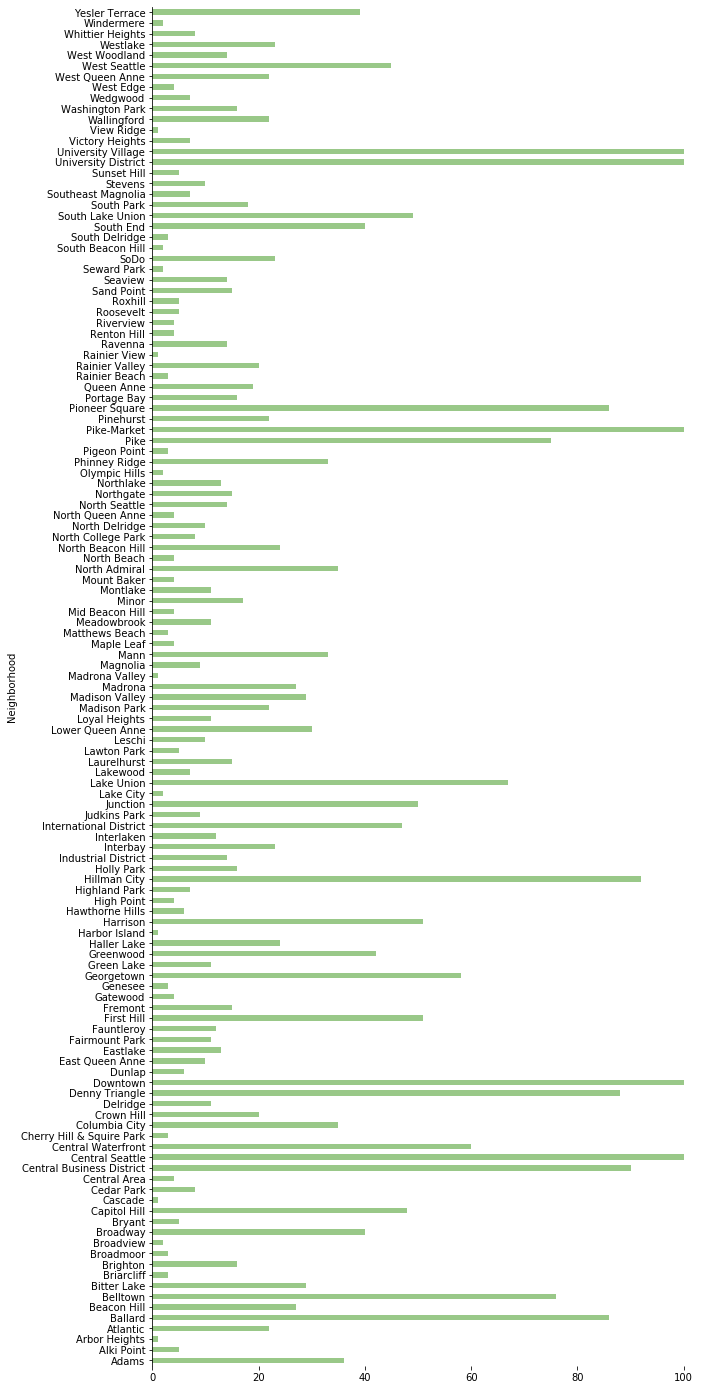

In [336]:
#check the distribution of venues in different venues
venues_counts = seattle_venues[["Neighborhood", "Venue Category"]].groupby("Neighborhood", as_index=False).count()
ax = venues_counts.plot(figsize=(10, 25), x="Neighborhood", kind="barh", color='#99c888')
#ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()
#ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", left="off", right="off", labelleft="on")

plt.savefig("count_bar.png")

In [125]:
# Apply one-hot encoding to Venue Category
#ohe = OneHotEncoder(sparse=False, dtype=int)          
seattle_oht = pd.concat([seattle_venues, pd.get_dummies(seattle_venues[["Venue Category"]], prefix='venue') ], axis=1)
seattle_grouped  = seattle_oht.groupby('Neighborhood').sum().reset_index()
seattle_grouped 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,venue_ATM,venue_Accessories Store,venue_Acupuncturist,venue_African Restaurant,venue_American Restaurant,...,venue_Video Store,venue_Vietnamese Restaurant,venue_Volleyball Court,venue_Warehouse,venue_Wine Bar,venue_Wine Shop,venue_Winery,venue_Wings Joint,venue_Women's Store,venue_Yoga Studio
0,Adams,1716.226920,-4405.953600,1716.135506,-4405.912226,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Alki Point,237.911772,-611.866435,237.913639,-611.865038,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arbor Heights,47.508610,-122.375930,47.510273,-122.376343,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Atlantic,1047.112220,-2690.649060,1047.163875,-2690.642026,0,0,0,1,0,...,0,2,0,0,0,0,0,0,0,0
4,Ballard,4099.505620,-10525.069580,4099.452646,-10524.984132,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
5,Beacon Hill,1284.575220,-3302.443170,1284.601967,-3302.410819,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,Belltown,3618.797760,-9298.192640,3618.749364,-9298.188646,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
7,Bitter Lake,1383.841720,-3548.158700,1383.855313,-3548.129312,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
8,Briarcliff,142.935000,-367.223220,142.940573,-367.228869,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Brighton,760.591840,-1956.402240,760.591773,-1956.421789,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Feature Selection
Since we are exploring the good positions for a Chinese restaurant, we do not need to consider all the venues, here we consider the number of restaurants, Chinese restaurants, shops, theaters, universities and tourism spots in a neighborhood. Then, after clustering, we give each neighbor a score, which is calculated as: num_rest+num_shops+num_tourism+num_university+num_theater-2*num_Chinese_restaurant.

In [172]:
seattle_venues.to_csv("seattle_venues.csv")

In [193]:
seattle_oht.to_csv("seattle_venues_oht.csv")

In [301]:
#feature selection: number of restaurants, Chinese restaurants, shopping malls, universities, travel & transport, museums
seattle_combined= seattle_oht.copy()
#list of travel
travel_list=[]
travel_list= seattle_oht['venue_Tourist Information Center'] + seattle_oht['venue_Museum']+seattle_oht['venue_Park']
seattle_combined.insert(4, 'Travel',travel_list)
#list of colleges
college_list=[]
college_list= seattle_oht['venue_General College & University'] + seattle_oht['venue_Community College'] +seattle_oht['venue_School']
seattle_combined.insert(5, 'College',college_list)
#list of restaurants
restaurant_list=[]
#restaurant_list= seattle_oht['venue_Food']
restaurant_list= sum(seattle_oht[i] for i in seattle_oht.columns if "Resturant" in i or "Food" in i)
seattle_combined.insert(6, 'Restaurant',restaurant_list)
#list of entertain
entertain_list=[]
entertain_list= seattle_oht['venue_Theater']+seattle_oht['venue_Movie Theater']
seattle_combined.insert(7, 'Theater',entertain_list)
#list of shopping
shopping_list=[]
shopping_list= sum(seattle_oht[i] for i in seattle_oht.columns if "Shop" in i)
seattle_combined.insert(8, 'Shopping',shopping_list)
#list of Chinese restaurants
CHN_list=[]
CHN_list= seattle_oht['venue_Chinese Restaurant']
seattle_combined.insert(9, 'CHNRestaurant',CHN_list)
seattle_combined.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Travel,College,Restaurant,Theater,Shopping,CHNRestaurant,...,venue_Video Store,venue_Vietnamese Restaurant,venue_Volleyball Court,venue_Warehouse,venue_Wine Bar,venue_Wine Shop,venue_Winery,venue_Wings Joint,venue_Women's Store,venue_Yoga Studio
0,North Seattle,47.643724,-122.302937,Cafe Lago,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,North Seattle,47.643724,-122.302937,Seattle Public Library - Montlake,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,North Seattle,47.643724,-122.302937,Montlake Cut,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,North Seattle,47.643724,-122.302937,Fuel Coffee - Montlake,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,North Seattle,47.643724,-122.302937,Montlake Blvd Market,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


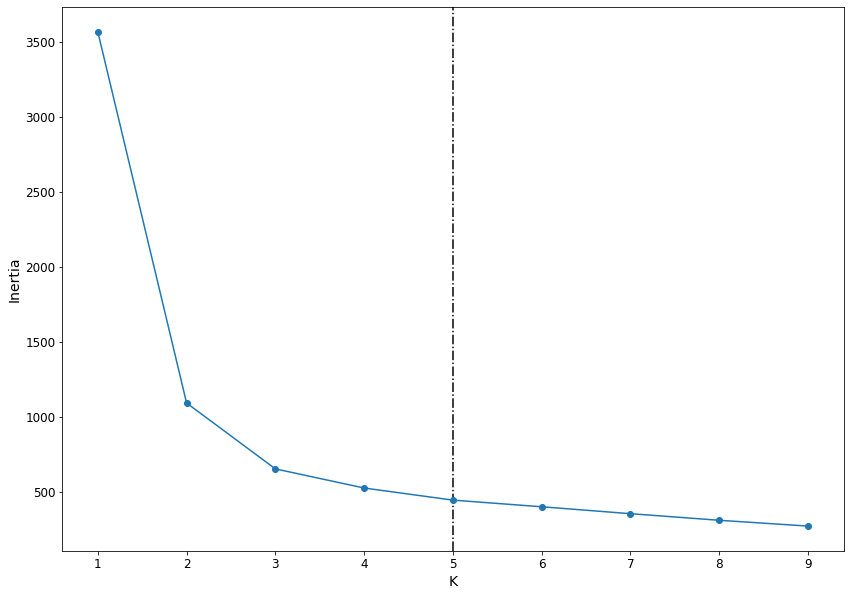

In [302]:
seattle_grouped_all  = seattle_combined.groupby('Neighborhood').sum().reset_index()
#only keep the selected features for clustering
seattle_grouped_clustering = seattle_grouped_all[['Travel', 'College', 'Restaurant',
       'Theater', 'Shopping', 'CHNRestaurant']]


# Use elbow methods to decide k
kmeans = list()
for k in range(1,10):
    kmeans.append(KMeans(n_clusters=k, random_state=0, ).fit(seattle_grouped_clustering))

plot_elbow(14,10, kmeans)
plt.savefig("elbow_plot.png")

In [303]:
best_k=5
kmeans_final = KMeans(n_clusters=best_k, random_state=0, ).fit(seattle_grouped_clustering)
seattle_grouped_clustering['Cluster'] = kmeans_final.labels_
seattle_grouped_clustering.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Travel,College,Restaurant,Theater,Shopping,CHNRestaurant,Cluster
0,1,0,0,0,5,0,2
1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0
3,1,0,0,0,3,0,2
4,0,0,2,0,14,1,3


In [304]:
clustered_df = seattle_grouped_clustering.copy()
clustered_df=clustered_df.astype(np.int32)
clustered_df['Score']=-2*clustered_df['CHNRestaurant']+clustered_df['Travel']+clustered_df['College']+clustered_df['Restaurant']+clustered_df['Theater']+clustered_df['Shopping']
clustered_df.head()

,Travel,College,Restaurant,Theater,Shopping,CHNRestaurant,Cluster,Score
0,1,0,0,0,5,0,2,6
1,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0
3,1,0,0,0,3,0,2,4
4,0,0,2,0,14,1,3,14


In [305]:
clustered=clustered_df.copy()
clustered = clustered[['Cluster', 'Score', 'Travel', 'Restaurant', 'Theater', 'Shopping','College', 'CHNRestaurant']]
# Group the dataset by cluster and sort by Score in descending order
#print(clustered_df)
result = clustered.groupby(['Cluster']).mean().sort_values(by='Score', ascending=False)
result

,Score,Travel,Restaurant,Theater,Shopping,College,CHNRestaurant
Cluster,,,,,,,
4,20.500000,0.333333,1.500000,1.333333,19.333333,0.000000,1.000000
3,16.666667,1.000000,1.833333,0.666667,14.166667,0.000000,0.500000
1,11.300000,1.200000,0.900000,0.600000,8.600000,0.000000,0.000000
2,4.500000,0.461538,0.461538,0.230769,4.192308,0.000000,0.423077
0,1.265823,0.607595,0.164557,0.037975,0.721519,0.037975,0.151899


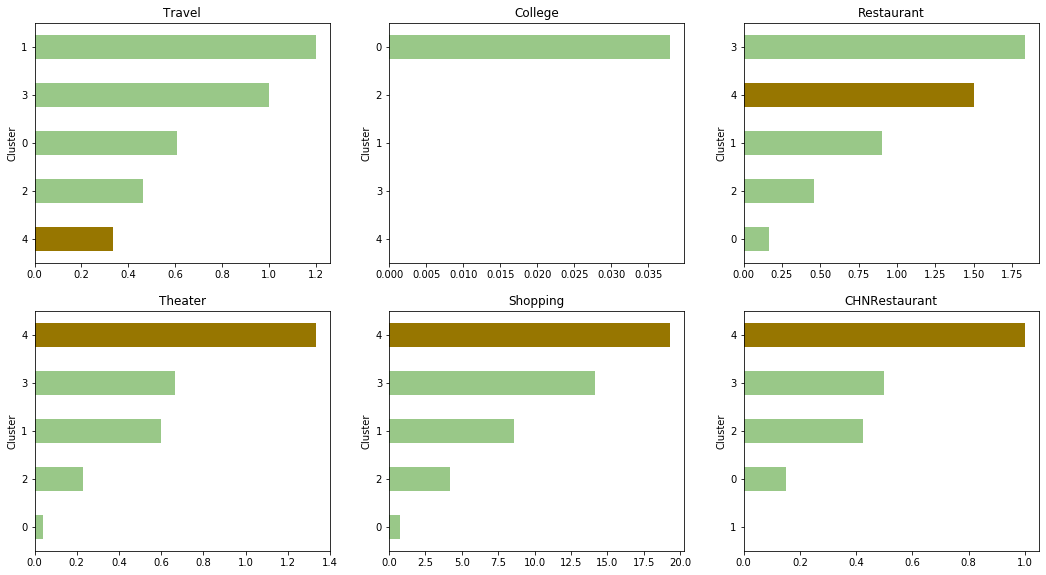

In [337]:
import matplotlib.pyplot as plt
import math
#check the distribution of selected venue types
def draw_barchart(dataframe, highlight_index):
    fig = plt.figure(figsize=(18, 15))
    n_rows = n_cols = math.ceil(math.sqrt(dataframe.columns.size))
    for i, col in enumerate(dataframe.columns):
        df = dataframe[[col]].sort_values(by=col)
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        df.plot.barh(ax=ax, color='#99c888')
        pos = df.index.get_loc(highlight_index)
        ax.patches[pos].set_facecolor('#977600')
        ax.set_title(col)
        ax.get_legend().remove()
    # fig.tight_layout()
    plt.show()

draw_barchart(result[['Travel','College', 'Restaurant','Theater','Shopping','CHNRestaurant']],4)


In [329]:
selection_df = clustered[clustered['Cluster'] == 4].sort_values(['Score'], ascending=[False]).head(6)
selected_neighborhoods = [seattle_venues['Neighborhood'][i] for i in selection_df.index]
selected_Latitude = [seattle_venues['Neighborhood Latitude'][i] for i in selection_df.index]
selected_Longitude = [seattle_venues['Neighborhood Longitude'][i] for i in selection_df.index]
selected_df = pd.DataFrame(list(zip(selected_neighborhoods, selected_Latitude, selected_Longitude)), 
               columns =['Neighborhood', 'Latitude', 'Longitude']) 
selected_df

,Neighborhood,Latitude,Longitude
0,Bitter Lake,47.71868,-122.35030
1,Northgate,47.71310,-122.31930
2,Bitter Lake,47.71868,-122.35030
3,Bitter Lake,47.71868,-122.35030
4,Greenwood,47.69082,-122.35529
5,Northgate,47.71310,-122.31930


In [330]:
map_seattle_selected = folium.Map(location=[47.6062,-122.3321],zoom_start=10)

for lat,lng,neighbourhood in zip(selected_df['Latitude'],selected_df['Longitude'],selected_df['Neighborhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_seattle_selected)
map_seattle_selected